# Forecasting beer sales 

### Source
- https://scikit-learn.org/stable/index.html
- https://www.mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/
- https://alkaline-ml.com/pmdarima/quickstart.html
- https://facebook.github.io/prophet/


- https://catboost.ai/docs/concepts/python-reference_catboostregressor.html


- https://www.analyticsvidhya.com/blog/2015/12/improve-machine-learning-results/
- https://www.analyticsvidhya.com/blog/2015/08/introduction-ensemble-learning/


## Install

In [143]:
# !pip install numpy
# !pip install pandas

# !pip install python-dotenv
# !pip install pyodbc

# !pip install sklearn
# !pip install joblib
# !pip install optuna

# !pip install lightgbm
# !pip install xgboost
# !pip install catboost

# !pip install matplotlib
# !pip install seaborn
# !pip install rfpimp
# !pip install skater
# !pip install eli5
# !pip install pandas-profiling
# !pip install ipywidgets

## Init

In [144]:
import pandas as pd
import numpy as np
import os
import datetime

import pyodbc
from dotenv import load_dotenv

from sklearn.experimental import enable_hist_gradient_boosting, enable_iterative_imputer
from sklearn import datasets, linear_model, ensemble, gaussian_process, isotonic, kernel_ridge, neighbors, neural_network, svm, tree
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, max_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold,train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, FunctionTransformer,  StandardScaler, LabelEncoder, LabelBinarizer, OrdinalEncoder, RobustScaler
from sklearn.inspection import permutation_importance
import joblib

import lightgbm  
import xgboost 
import catboost
# from keras.wrappers.scikit_learn import KerasRegressor
# from keras.models import Sequential
# from keras.layers import Dense
import optuna

# visualization lib
import matplotlib.pyplot as plt
import seaborn as sns
from rfpimp import permutation_importances, plot_importances, plot_corr_heatmap
# import shap
import eli5
from eli5.sklearn import PermutationImportance
from pandas_profiling import ProfileReport

from helper import absolute_score, show_pred, show_feature_importances, reduce_mem_usage

In [145]:
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

In [146]:
load_dotenv()

True

In [147]:
DATASET_MARKET = 'off-trade'
DATASET_COUNTRY = 'all'

DATASET_NAME = f'{DATASET_MARKET}_{DATASET_COUNTRY}'

if (DATASET_MARKET == 'on-trade'):
    DATASET_FROM_YEAR = 2021
    DATASET_FROM_WEEK = 25
    DATASET_TO_YEAR = 2021
    DATASET_TO_WEEK = 30

if (DATASET_MARKET == 'off-trade'):
    DATASET_FROM_YEAR = 2021
    DATASET_FROM_WEEK = 25
    DATASET_TO_YEAR = 2021
    DATASET_TO_WEEK = 30

DATA_PATH = f'./data/{DATASET_NAME}_data.csv'

MODEL_PATH = f'./models/{DATASET_NAME}_model.joblib'
SCALER_PATH = f'./models/{DATASET_NAME}_scaler.joblib'
IMPUTER_PATH = f'./models/{DATASET_NAME}_imputer.joblib'
SKU_ENCODER_PATH = f'./models/{DATASET_NAME}_sku_encoder.joblib'
BRAND_ENCODER_PATH = f'./models/{DATASET_NAME}_brand_encoder.joblib'

RESULT_CSV_PATH = f'./train_results/{DATASET_NAME}_train_result.csv'
RESULT_EXCEL_PATH = f'./train_results/{DATASET_NAME}_train_result.xlsx'

MAX_N_JOBS = 8

## Load Data

In [148]:
try:
    server = os.getenv('DB_SERVER')
    database = os.getenv('DB_DATABASE')
    username = os.getenv('DB_USERNAME')
    password = os.getenv('DB_PASSWORD')

    cnxn = pyodbc.connect(f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}') 

    country_par = 'NULL' if DATASET_COUNTRY == 'all' else DATASET_COUNTRY
    query1=f'EXEC [dbo].[ML_Table_extension_data] @Country={country_par}, @FromYear={DATASET_FROM_YEAR}, @FromWeek={DATASET_FROM_WEEK}, @ToYear={DATASET_TO_YEAR}, @ToWeek={DATASET_TO_WEEK}, @Market="{DATASET_MARKET.upper()}"'
    
    data = pd.read_sql(query1, cnxn)

    data.to_csv(DATA_PATH, index=False)
except:
    print("Unexpected error:", sys.exc_info()[0])
    data = data.sort_values(by=['Year', 'Week', 'SkuShort', 'Country']).reset_index().drop(columns=['index'])
else:
    cnxn.close()

data.head()

Unexpected error: <class 'pyodbc.OperationalError'>


,SkuShort,Brand,Country,Year,Week,NumberWorkdays,PrevNumberWorkdays,NextNumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,SalesHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,OldPredSalesHl
0,01015,PILSNER URQUELL,CZ,2016,1,5,NaN,5.0,-1.164062,0.935547,1.014648,False,NaN,NaN,1637.00000,1805.0000,NaN,NaN,NaN,NaN,705.500000
1,01015,PILSNER URQUELL,SK,2016,1,4,NaN,4.0,-1.164062,0.935547,1.014648,False,NaN,NaN,631.00000,506.9000,NaN,NaN,NaN,NaN,600.000000
2,01016,PILSNER URQUELL,CZ,2016,1,5,NaN,5.0,-1.164062,0.935547,1.014648,False,NaN,NaN,293.25000,159.1128,NaN,NaN,NaN,NaN,160.125000
3,01016,PILSNER URQUELL,SK,2016,1,4,NaN,4.0,-1.164062,0.935547,1.014648,False,NaN,NaN,40.87500,26.9280,NaN,NaN,NaN,NaN,2.822266
4,01022,PILSNER URQUELL,CZ,2016,1,5,NaN,5.0,-1.164062,0.935547,1.014648,False,NaN,NaN,59.15625,72.4900,NaN,NaN,NaN,NaN,74.437500


In [149]:
data = reduce_mem_usage(data, ignoreCols=['SalesHl'])

Mem. usage decreased to  3.17 Mb (0.0% reduction)


In [150]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52725 entries, 0 to 52724
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SkuShort            52725 non-null  object 
 1   Brand               52725 non-null  object 
 2   Country             52725 non-null  object 
 3   Year                52725 non-null  int16  
 4   Week                52725 non-null  int8   
 5   NumberWorkdays      52725 non-null  int8   
 6   PrevNumberWorkdays  52585 non-null  float16
 7   NextNumberWorkdays  48793 non-null  float16
 8   AvgTemp             52725 non-null  float16
 9   AvgRain             52725 non-null  float16
 10  AvgSun              52725 non-null  float16
 11  IsLockdown          52725 non-null  bool   
 12  PdtHl               32154 non-null  float16
 13  PrevWeekPdtHl1      31791 non-null  float16
 14  BgtHl               45456 non-null  float16
 15  SalesHl             45590 non-null  float64
 16  Prev

In [151]:
data.describe()

,Year,Week,NumberWorkdays,PrevNumberWorkdays,NextNumberWorkdays,AvgTemp,AvgRain,AvgSun,PdtHl,PrevWeekPdtHl1,BgtHl,SalesHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,OldPredSalesHl
count,52725.000000,52725.000000,52725.000000,5.258500e+04,4.879300e+04,5.272500e+04,5.272500e+04,5.272500e+04,3.215400e+04,3.179100e+04,45456.0000,45590.000000,4.510000e+04,4.476600e+04,3.487800e+04,2.463900e+04,4.411100e+04
mean,2018.330925,26.292973,4.778568,inf,inf,inf,inf,inf,inf,inf,inf,645.663899,inf,inf,inf,inf,inf
std,1.504186,15.228212,0.505222,5.107422e-01,4.216309e-01,7.718750e+00,1.624023e+00,3.021484e+00,inf,inf,inf,1560.379651,inf,inf,inf,inf,inf
min,2016.000000,1.000000,2.000000,2.000000e+00,4.000000e+00,-8.281250e+00,0.000000e+00,1.428223e-01,2.174377e-02,2.174377e-02,-28.5625,0.020000,2.000427e-02,2.000427e-02,3.500366e-02,2.000427e-02,6.210327e-02
25%,2017.000000,13.000000,5.000000,5.000000e+00,4.000000e+00,3.357422e+00,4.152832e-01,2.164062e+00,2.500000e+01,2.500000e+01,38.3750,28.116000,2.889062e+01,2.900000e+01,3.318750e+01,4.309375e+01,3.600000e+01
50%,2018.000000,26.000000,5.000000,5.000000e+00,4.000000e+00,9.960938e+00,1.130859e+00,4.570312e+00,1.188750e+02,1.181875e+02,154.6250,130.710000,1.326250e+02,1.327500e+02,1.470000e+02,1.658750e+02,1.490000e+02
75%,2020.000000,40.000000,5.000000,5.000000e+00,4.000000e+00,1.767188e+01,2.306641e+00,7.121094e+00,4.730000e+02,4.697500e+02,561.0000,555.481600,5.605000e+02,5.600000e+02,5.790000e+02,6.260000e+02,5.925000e+02
max,2021.000000,53.000000,5.000000,5.000000e+00,5.000000e+00,2.581250e+01,7.957031e+00,1.386719e+01,3.846400e+04,3.846400e+04,16008.0000,24281.500000,2.428800e+04,2.428800e+04,2.428800e+04,2.315200e+04,2.486400e+04


## Missing Values

In [152]:
data.isna().sum()

SkuShort              0    
Brand                 0    
Country               0    
Year                  0    
Week                  0    
NumberWorkdays        0    
PrevNumberWorkdays    140  
NextNumberWorkdays    3932 
AvgTemp               0    
AvgRain               0    
AvgSun                0    
IsLockdown            0    
PdtHl                 20571
PrevWeekPdtHl1        20934
BgtHl                 7269 
SalesHl               7135 
PrevWeekSalesHl1      7625 
PrevWeekSalesHl2      7959 
PrevYearSalesHl1      17847
PrevYearSalesHl2      28086
OldPredSalesHl        8614 
dtype: int64

## Data Visualizations

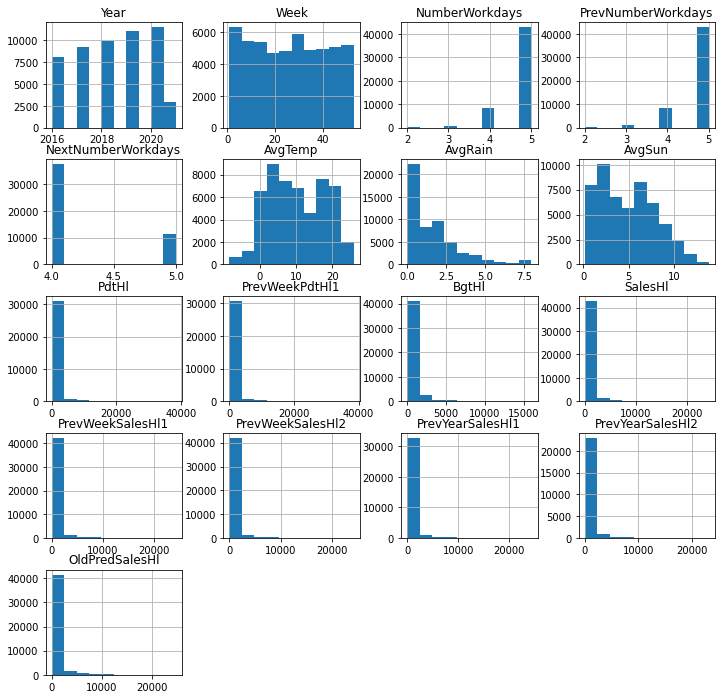

In [153]:
data.hist(figsize=[12,12])
plt.show()

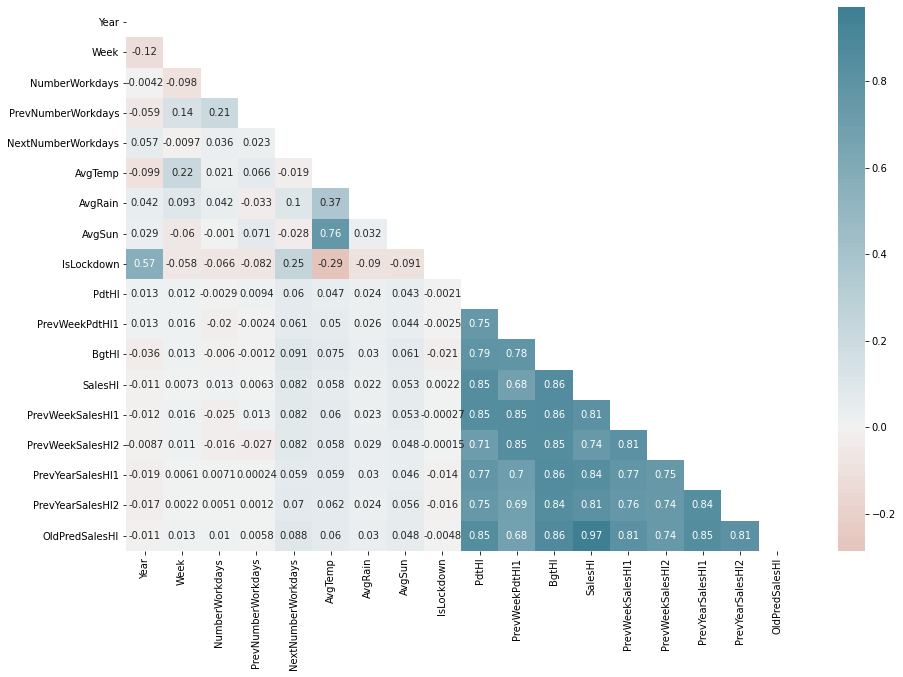

In [154]:
plt.subplots(figsize = (15,10))
mask = np.zeros_like(data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data.corr(), cmap=sns.diverging_palette(20, 220, n=200), annot=True, mask=mask, center = 0)
plt.show()

In [155]:
numData = data.select_dtypes(exclude='object')
numDatacorr = numData.corr()
salesHlFrame = numDatacorr['SalesHl'].sort_values(ascending=False).head(10).to_frame()

salesHlFrame.style.background_gradient(cmap=sns.light_palette("cyan", as_cmap=True))

,SalesHl
SalesHl,1.000000
OldPredSalesHl,0.971360
BgtHl,0.857940
PdtHl,0.845968
PrevYearSalesHl1,0.842308
PrevWeekSalesHl1,0.811500
PrevYearSalesHl2,0.805982
PrevWeekSalesHl2,0.736208
PrevWeekPdtHl1,0.677344
NextNumberWorkdays,0.082371


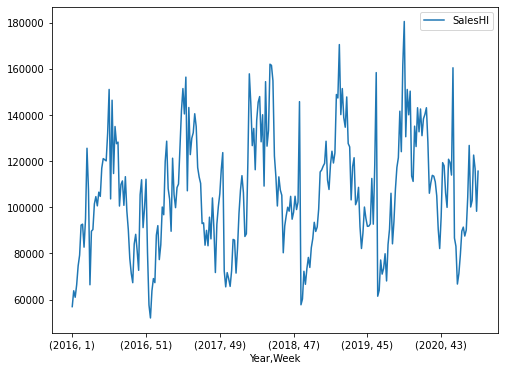

In [156]:
data.groupby(['Year','Week']).sum().plot(y=['SalesHl'], figsize=(8,6))
plt.show()

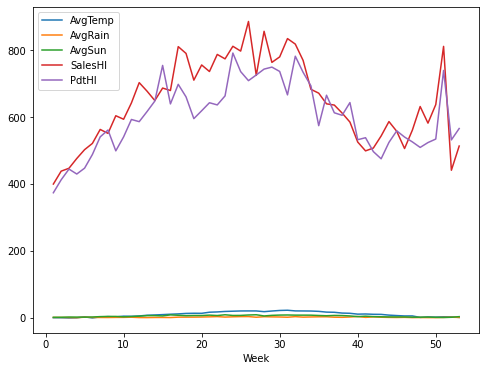

In [157]:
data.groupby(['Week']).mean().plot(y=['AvgTemp', 'AvgRain', 'AvgSun', 'SalesHl', 'PdtHl'], figsize=(8,6))
plt.show()

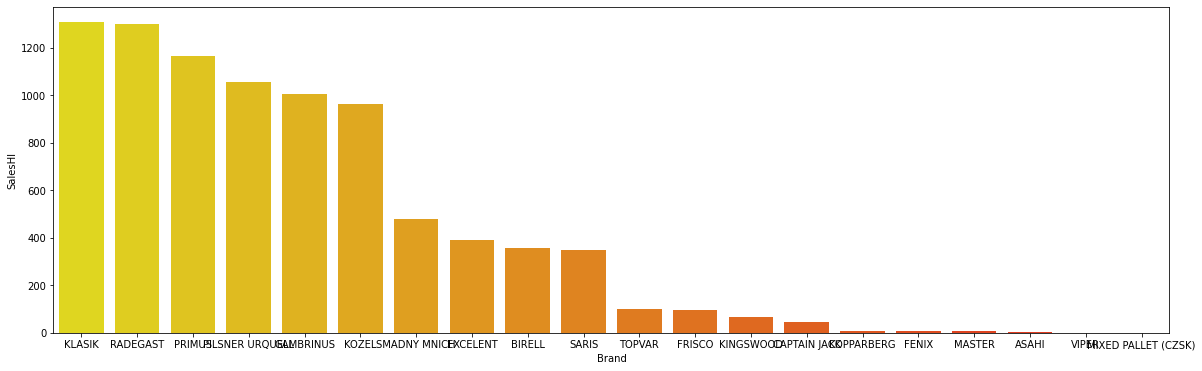

In [158]:
plt.figure(figsize=(20,6))
g_pps = data.groupby('Brand')['SalesHl'].mean().sort_values(ascending=False)
axis = sns.barplot(x=g_pps.index, y=g_pps, palette='autumn_r')
axis.set_xlabel('Brand')
axis.set_ylabel('SalesHl')

plt.show()

## Skewness and Kurtesis

In [159]:
data.skew()

SkuShort              0.730638
Year                 -0.067406
Week                  0.027815
NumberWorkdays       -2.617859
PrevNumberWorkdays   -inf     
NextNumberWorkdays    inf     
AvgTemp               inf     
AvgRain               inf     
AvgSun                inf     
IsLockdown            1.992866
PdtHl                 inf     
PrevWeekPdtHl1        inf     
BgtHl                 inf     
SalesHl               5.401654
PrevWeekSalesHl1      inf     
PrevWeekSalesHl2      inf     
PrevYearSalesHl1      inf     
PrevYearSalesHl2      inf     
OldPredSalesHl        inf     
dtype: float64

In [160]:
data.kurt()

SkuShort              0.059714 
Year                 -1.115098 
Week                 -1.234394 
NumberWorkdays        7.944689 
PrevNumberWorkdays   NaN       
NextNumberWorkdays   NaN       
AvgTemp              NaN       
AvgRain              NaN       
AvgSun               NaN       
IsLockdown            1.971589 
PdtHl                NaN       
PrevWeekPdtHl1       NaN       
BgtHl                NaN       
SalesHl               38.540323
PrevWeekSalesHl1     NaN       
PrevWeekSalesHl2     NaN       
PrevYearSalesHl1     NaN       
PrevYearSalesHl2     NaN       
OldPredSalesHl       NaN       
dtype: float64

In [161]:

# profile = ProfileReport(data, minimal=True)
# profile.to_notebook_iframe()

## Spliting data in X and Y

In [162]:
cols_drop = ['SalesHl', 'OldPredSalesHl'] #'SkuShort', 'ProductGroup', 'PrimaryPack', 'Country', 'Year', 'BgtHl', 'Brand', 'SubBrand'

X = data.drop(cols_drop, axis=1)
X_raw = X.copy(deep=True)
y = data.SalesHl.fillna(0).to_numpy()
y_oldPred = data.OldPredSalesHl.fillna(0).to_numpy()

In [163]:
# # X['NextWeek'] = X['Week']+1
# # X = X.merge(workdays, how='left', left_on=['Country','Year','NextWeek'], right_on=['Country','Year','Week'], suffixes=(None, "Next"))
# # X = X.drop(['NextWeek',  'WeekNext'], axis=1) 
# # X['NumberWorkdaysNext'] = X['NumberWorkdaysNext'].fillna(5)

# # X['PrevWeek'] = X['Week']-1
# # X = X.merge(workdays, how='left', left_on=['Country','Year','PrevWeek'], right_on=['Country','Year','Week'], suffixes=(None, "Prev"))
# # X = X.drop(['PrevWeek', 'WeekPrev', ], axis=1) #'NextWeek',  'WeekNext'
# # X['NumberWorkdaysPrev'] = X['NumberWorkdaysPrev'].fillna(5)

# X['NextWeek'] = X['Week']+1
# X['PrevWeek'] = X['Week']-1

# X = X.merge(workdays, how='left', left_on=['Country','Year','NextWeek'], right_on=['Country','Year','Week'], suffixes=(None, "Next"))
# X = X.merge(workdays, how='left', left_on=['Country','Year','PrevWeek'], right_on=['Country','Year','Week'], suffixes=(None, "Prev"))

# X = X.drop(['PrevWeek', 'WeekPrev', 'NextWeek',  'WeekNext'], axis=1)
# X['NumberWorkdaysPrev'] = X['NumberWorkdaysPrev'].fillna(5)
# X['NumberWorkdaysNext'] = X['NumberWorkdaysNext'].fillna(5)
# X

## LabelEncoder

In [164]:
Country_mapping = {"CZ": 1, "SK": 2}
# PrimaryPack_mapping = {"CAN": 1, "KEG": 2, "RB": 3, "NRB": 4, "TANK": 5, "PET": 6, "KEG ONE WAY": 7, "KEG WOODEN": 8}
# ProductGroup_mapping = {"CLEAR BEER": 1, "FLAVOURED BEER": 2, "CIDER": 3, "SOFT DRINKS": 4, "MALT BASED BEV": 5, "WHEAT BEER": 6, "FABS - Seltzer sugar base": 7, "CLEAR BEER - MIXED PALLET (CZSK)": 8}

X.Country = X.Country.map(Country_mapping)
# X.PrimaryPack = X.PrimaryPack.map(PrimaryPack_mapping)
# X.ProductGroup =  X.ProductGroup.map(ProductGroup_mapping)

sku_encoder = LabelEncoder()
X.SkuShort = sku_encoder.fit_transform(X.SkuShort)

brand_encoder = LabelEncoder()
X.Brand = brand_encoder.fit_transform(X.Brand)
# X.SubBrand = LabelEncoder().fit_transform(X.SubBrand)

X.head()

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,PrevNumberWorkdays,NextNumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2
0,0,13,1,2016,1,5,NaN,5.0,-1.164062,0.935547,1.014648,False,NaN,NaN,1637.00000,NaN,NaN,NaN,NaN
1,0,13,2,2016,1,4,NaN,4.0,-1.164062,0.935547,1.014648,False,NaN,NaN,631.00000,NaN,NaN,NaN,NaN
2,1,13,1,2016,1,5,NaN,5.0,-1.164062,0.935547,1.014648,False,NaN,NaN,293.25000,NaN,NaN,NaN,NaN
3,1,13,2,2016,1,4,NaN,4.0,-1.164062,0.935547,1.014648,False,NaN,NaN,40.87500,NaN,NaN,NaN,NaN
4,2,13,1,2016,1,5,NaN,5.0,-1.164062,0.935547,1.014648,False,NaN,NaN,59.15625,NaN,NaN,NaN,NaN


## Imputer

In [165]:
X.BgtHl = X.BgtHl.fillna(0)
X.PdtHl = X.PdtHl.fillna(0)
X.PrevWeekPdtHl1 = X.PrevWeekPdtHl1.fillna(0)

In [166]:
imputer = SimpleImputer(strategy='mean')
# imputer = SimpleImputer(strategy='constant', fill_value=0)
# imputer = IterativeImputer(random_state=0, skip_complete=True, min_value=0) #649.619645	
# imputer = KNNImputer()

X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
X

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,PrevNumberWorkdays,NextNumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2
0,0.0,13.0,1.0,2016.0,1.0,5.0,4.776191,5.00000,-1.164062,0.935547,1.014648,0.0,0.000000,0.000000,1637.000000,648.779746,650.267796,659.153768,697.943086
1,0.0,13.0,2.0,2016.0,1.0,4.0,4.776191,4.00000,-1.164062,0.935547,1.014648,0.0,0.000000,0.000000,631.000000,648.779746,650.267796,659.153768,697.943086
2,1.0,13.0,1.0,2016.0,1.0,5.0,4.776191,5.00000,-1.164062,0.935547,1.014648,0.0,0.000000,0.000000,293.250000,648.779746,650.267796,659.153768,697.943086
3,1.0,13.0,2.0,2016.0,1.0,4.0,4.776191,4.00000,-1.164062,0.935547,1.014648,0.0,0.000000,0.000000,40.875000,648.779746,650.267796,659.153768,697.943086
4,2.0,13.0,1.0,2016.0,1.0,5.0,4.776191,5.00000,-1.164062,0.935547,1.014648,0.0,0.000000,0.000000,59.156250,648.779746,650.267796,659.153768,697.943086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52720,278.0,17.0,2.0,2021.0,15.0,5.0,4.000000,4.23114,3.277344,1.753906,1.525391,1.0,0.000000,632.000000,249.500000,648.779746,614.000000,748.500000,697.943086
52721,280.0,17.0,2.0,2021.0,15.0,5.0,4.000000,4.23114,3.277344,1.753906,1.525391,1.0,1.320312,1.320312,2.988281,648.779746,650.267796,13.320312,22.437500
52722,283.0,17.0,2.0,2021.0,15.0,5.0,4.000000,4.23114,3.277344,1.753906,1.525391,1.0,1.474609,1.474609,83.812500,58.093750,16.437500,48.250000,105.375000
52723,284.0,17.0,2.0,2021.0,15.0,5.0,4.000000,4.23114,3.277344,1.753906,1.525391,1.0,0.000000,357.500000,166.250000,648.779746,354.750000,415.750000,697.943086


## Adding a New Feature

In [167]:
#Avg 
X['AvgPrevWeekSalesHl'] = X[['PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(1)
X['AvgPrevYearSalesHl'] = X[['PrevYearSalesHl1', 'PrevYearSalesHl2']].mean(axis=1).round(1)
X['AvgPrevAllSalesHl'] = X[['PrevYearSalesHl1', 'PrevYearSalesHl2', 'PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(1)

X

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,PrevNumberWorkdays,NextNumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,AvgPrevWeekSalesHl,AvgPrevYearSalesHl,AvgPrevAllSalesHl
0,0.0,13.0,1.0,2016.0,1.0,5.0,4.776191,5.00000,-1.164062,0.935547,1.014648,0.0,0.000000,0.000000,1637.000000,648.779746,650.267796,659.153768,697.943086,649.5,678.5,664.0
1,0.0,13.0,2.0,2016.0,1.0,4.0,4.776191,4.00000,-1.164062,0.935547,1.014648,0.0,0.000000,0.000000,631.000000,648.779746,650.267796,659.153768,697.943086,649.5,678.5,664.0
2,1.0,13.0,1.0,2016.0,1.0,5.0,4.776191,5.00000,-1.164062,0.935547,1.014648,0.0,0.000000,0.000000,293.250000,648.779746,650.267796,659.153768,697.943086,649.5,678.5,664.0
3,1.0,13.0,2.0,2016.0,1.0,4.0,4.776191,4.00000,-1.164062,0.935547,1.014648,0.0,0.000000,0.000000,40.875000,648.779746,650.267796,659.153768,697.943086,649.5,678.5,664.0
4,2.0,13.0,1.0,2016.0,1.0,5.0,4.776191,5.00000,-1.164062,0.935547,1.014648,0.0,0.000000,0.000000,59.156250,648.779746,650.267796,659.153768,697.943086,649.5,678.5,664.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52720,278.0,17.0,2.0,2021.0,15.0,5.0,4.000000,4.23114,3.277344,1.753906,1.525391,1.0,0.000000,632.000000,249.500000,648.779746,614.000000,748.500000,697.943086,631.4,723.2,677.3
52721,280.0,17.0,2.0,2021.0,15.0,5.0,4.000000,4.23114,3.277344,1.753906,1.525391,1.0,1.320312,1.320312,2.988281,648.779746,650.267796,13.320312,22.437500,649.5,17.9,333.7
52722,283.0,17.0,2.0,2021.0,15.0,5.0,4.000000,4.23114,3.277344,1.753906,1.525391,1.0,1.474609,1.474609,83.812500,58.093750,16.437500,48.250000,105.375000,37.3,76.8,57.0
52723,284.0,17.0,2.0,2021.0,15.0,5.0,4.000000,4.23114,3.277344,1.753906,1.525391,1.0,0.000000,357.500000,166.250000,648.779746,354.750000,415.750000,697.943086,501.8,556.8,529.3


## Split train and test

In [168]:
train_index = len(X[(X.Year <= 2020) | ((X.Year == 2021) & (X.Week < 15))])
# train_index = len(X[(X.Year <= 2019) | ((X.Year == 2020) & (X.Week < 45))])

# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 21)
 
X_train = X.iloc[:train_index]
y_train = y[:train_index]

X_test = X.iloc[train_index:]
X_test_raw = X_raw.iloc[train_index:]
y_test = y[train_index:]
y_test_oldPred = y_oldPred[train_index:]

## Scaler

In [169]:
# transformers = [
#     ("ignore1", 'passthrough', ['SkuShort','Brand','Country','Year','Week','NumberWorkdays']),
#     ("num1", StandardScaler(), ['AvgTemp', 'AvgRain', 'AvgSun']),
#     ("ignore2", 'passthrough', ['IsLockdown']),
#     ("num2", StandardScaler(), ['PdtHl', 'PrevWeekPdtHl1', 'BgtHl', 'PrevWeekSalesHl1', 'PrevWeekSalesHl2', 'PrevYearSalesHl1','PrevYearSalesHl2']),
#     ("ignore3", 'passthrough', ['NumberWorkdaysNext', 'NumberWorkdaysPrev']),
#     ("num3", StandardScaler(), ['AvgPrevWeekSalesHl','AvgPrevYearSalesHl','AvgPrevAllSalesHl']),
# ]

# transformer = ColumnTransformer(transformers = transformers)

# X = pd.DataFrame(transformer.fit_transform(X), columns=X.columns)
# X

In [170]:
# scaler = MinMaxScaler()
# scaler = MaxAbsScaler()
scaler = StandardScaler() 
# scaler = RobustScaler()

scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
X_train

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,PrevNumberWorkdays,NextNumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,AvgPrevWeekSalesHl,AvgPrevYearSalesHl,AvgPrevAllSalesHl
0,-1.627427,0.860730,-0.826255,-1.549257,-1.662408,0.439325,-0.006042,1.892159,-1.481516,-0.435334,-1.280601,-0.409662,-0.295589,-0.292932,0.865713,-0.000090,0.000110,0.000577,0.000244,-0.000004,0.000425,0.000197
1,-1.627427,0.860730,1.210280,-1.549257,-1.662408,-1.536864,-0.006042,-0.568833,-1.481516,-0.435334,-1.280601,-0.409662,-0.295589,-0.292932,0.079552,-0.000090,0.000110,0.000577,0.000244,-0.000004,0.000425,0.000197
2,-1.615021,0.860730,-0.826255,-1.549257,-1.662408,0.439325,-0.006042,1.892159,-1.481516,-0.435334,-1.280601,-0.409662,-0.295589,-0.292932,-0.184390,-0.000090,0.000110,0.000577,0.000244,-0.000004,0.000425,0.000197
3,-1.615021,0.860730,1.210280,-1.549257,-1.662408,-1.536864,-0.006042,-0.568833,-1.481516,-0.435334,-1.280601,-0.409662,-0.295589,-0.292932,-0.381615,-0.000090,0.000110,0.000577,0.000244,-0.000004,0.000425,0.000197
4,-1.602616,0.860730,-0.826255,-1.549257,-1.662408,0.439325,-0.006042,1.892159,-1.481516,-0.435334,-1.280601,-0.409662,-0.295589,-0.292932,-0.367328,-0.000090,0.000110,0.000577,0.000244,-0.000004,0.000425,0.000197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52512,1.821276,1.587121,1.210280,1.789150,-0.809477,-1.536864,-1.531591,0.000000,-0.710955,-0.541530,0.324814,2.441036,0.216085,-0.292932,-0.218580,-0.024126,0.000110,0.000577,0.000244,-0.012668,0.000425,-0.007399
52513,1.846087,1.587121,1.210280,1.789150,-0.809477,-1.536864,-1.531591,0.000000,-0.710955,-0.541530,0.324814,2.441036,-0.294520,-0.291818,-0.411222,-0.000090,0.000110,-0.503705,-0.598896,-0.000004,-0.591603,-0.285638
52514,1.858492,1.587121,1.210280,1.789150,-0.809477,-1.536864,-1.531591,0.000000,-0.710955,-0.541530,0.324814,2.441036,-0.086912,-0.292932,-0.413557,-0.273698,0.000110,0.000577,0.000244,-0.144034,0.000425,-0.086147
52515,1.883303,1.587121,1.210280,1.789150,-0.809477,-1.536864,-1.531591,0.000000,-0.710955,-0.541530,0.324814,2.441036,-0.294395,-0.291246,-0.348060,-0.437099,-0.424029,-0.472800,-0.553004,-0.453418,-0.550652,-0.537861


## Regressors

In [171]:
# model = ensemble.AdaBoostRegressor()
# model = tree.DecisionTreeRegressor(random_state=0)
#model = ensemble.BaggingRegressor(base_estimator=svm.SVR(), bootstrap=True, bootstrap_features=False, n_estimators=200, oob_score=False, warm_start=True)
#model = ensemble.ExtraTreesRegressor(n_jobs=3)
# model = ensemble.GradientBoostingRegressor()
#model = ensemble.RandomForestRegressor(n_estimators=1000, n_jobs=3, bootstrap=True, criterion='mse', oob_score=True)
#NOT model = ensemble.StackingRegressor(estimators=[('lgbm', lgb.LGBMRegressor()),('hgb', ensemble.HistGradientBoostingRegressor())],final_estimator=ensemble.BaggingRegressor(), n_jobs=4, passthrough=False) 
#model = ensemble.VotingRegressor([('lgbm', lgb.LGBMRegressor(n_estimators=5000, learning_rate=0.005)), ('rf', ensemble.RandomForestRegressor(n_estimators=1000))])
#model = ensemble.HistGradientBoostingRegressor(random_state=1, loss='least_squares', learning_rate=0.05, max_iter=350, max_leaf_nodes=70, early_stopping=False)

#NOT model = gaussian_process.GaussianProcessRegressor()
#NOT model = isotonic.IsotonicRegression()

#NOT model = kernel_ridge.KernelRidge(alpha=1.0)

#model = linear_model.LogisticRegression(max_iter=10)
# model = linear_model.LinearRegression(copy_X=True, fit_intercept=True, normalize=False, positive=False)
# model = linear_model.Ridge(max_iter=1000, copy_X=True, fit_intercept=True, normalize=True, solver='sparse_cg')
# model = linear_model.SGDRegressor(max_iter=1500, early_stopping=False, alpha=0.0001, average=True, epsilon=0.1,eta0=0.01, fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling', loss='huber', penalty='l2', power_t=0.1, shuffle=True, warm_start=True)

# model = linear_model.ElasticNet(max_iter=2000, alpha=0.001, copy_X=False, fit_intercept=True, l1_ratio=1, normalize=True, positive=False, precompute=False, selection='random', warm_start=True)
# model = linear_model.Lars(n_nonzero_coefs=1000) 
# model = linear_model.LassoLars(max_iter=500) 
# model = linear_model.OrthogonalMatchingPursuit()
# model = linear_model.ARDRegression(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=False) 
# model = linear_model.BayesianRidge(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=True) 

# model = linear_model.HuberRegressor(max_iter=500, epsilon=1.6, fit_intercept=True, warm_start=True) 
# model = linear_model.RANSACRegressor(max_trials=500)
# model = linear_model.TheilSenRegressor(max_iter=500, n_jobs=-1)

#NOT model = linear_model.PoissonRegressor(max_iter=500)
# model = linear_model.TweedieRegressor(max_iter=500, alpha=0.05, fit_intercept=False, link='auto', power=0, warm_start=True) 
#NOT model = linear_model.GammaRegressor(max_iter=500) 
#NOT model = linear_model.PassiveAggressiveRegressor(random_state=0, fit_intercept=True) 

# model = neighbors.KNeighborsRegressor(n_neighbors=7, weights='uniform', leaf_size=30, n_jobs=-1) 
# model = neighbors.RadiusNeighborsRegressor(radius=5.0, weights='distance')

#NOT model = svm.LinearSVR()

#model = xgboost.XGBRegressor(random_state=0, tree_method='approx', booster='dart', colsample_bytree= 0.5, gamma=0.0, learning_rate=0.2, max_depth=3, reg_lambda=20, min_child_weight=2, n_jobs=MAX_N_JOBS)#0.81 #reg_lambda=20,

## Find best params

In [172]:
# model = xgboost.XGBRegressor(random_state=0, tree_method='approx', booster='dart',  importance_type='gain', reg_lambda=10, reg_alpha=23, colsample_bytree= 0.5, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_jobs=MAX_N_JOBS)#0.81 #reg_lambda=20,

# param_grid = dict(base_score =[ 0.25, 0.3, 0.35, 0.4,]) #importance_type=['gain', 'weight', 'cover','total_gain','total_cover']
# clf = GridSearchCV(model, param_grid, n_jobs=2) #, random_state=0
# search = clf.fit(X_train, y_train)
# #print(search.cv_results_)
# print(search.best_score_)
# print(search.best_params_)

In [173]:
# model = xgboost.XGBRegressor(random_state=0, tree_method='approx', booster='dart', importance_type='gain',  reg_lambda=10, reg_alpha=23, colsample_bytree= 0.5, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=100,n_jobs=MAX_N_JOBS)#0.9168

# # Train the model using the training sets
# model.fit(X_train, y_train)

# # Make predictions using the testing set
# y_pred = model.predict(X_test)
# y_pred[y_pred < 0] = 0
# y_pred = y_pred.round(0)

# print(DATASET_NAME)
# print('Coefficient of determination: %.4f'% r2_score(y_test, y_pred))
# print('Absolute Score: %.4f'% absolute_score(y_test, y_pred))
# print('Mean absolute error regression loss.: %.4f'% mean_absolute_error(y_test, y_pred))
# print('Maximum residual error: %.4f'% max_error(y_test, y_pred))
# print('Mean squared error regression loss: %.4f'% mean_squared_error(y_test, y_pred))

## Models

### HistGradientBoostingRegressor 

In [174]:
hgbModel = ensemble.HistGradientBoostingRegressor(random_state=0, loss='least_squares', learning_rate=0.05, max_iter=250, max_leaf_nodes=150, min_samples_leaf=25, early_stopping=False)

### MLPRegressor

In [175]:
mlpModel = neural_network.MLPRegressor(random_state=0, activation='relu', solver='adam', hidden_layer_sizes=100, shuffle=False, warm_start=True, max_iter=1000, early_stopping=False)

### RandomForestRegressor

In [176]:
rfModel = ensemble.RandomForestRegressor(random_state=0, criterion='mse', min_samples_split=2, min_samples_leaf=3, n_estimators=100, max_depth=None, max_features=None, bootstrap=True, oob_score=True, n_jobs=MAX_N_JOBS)

### XGBRegressor

In [177]:
xgbModel = xgboost.XGBRegressor(random_state=0, tree_method='approx', booster='dart', importance_type='gain',  reg_lambda=10, reg_alpha=23, colsample_bytree= 0.5, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=100,n_jobs=MAX_N_JOBS)

### CatBoostRegressor

In [178]:
cbModel = catboost.CatBoostRegressor(learning_rate=0.05, eval_metric='RMSE', loss_function='RMSE', bootstrap_type='No', leaf_estimation_method='Newton', random_seed=42, verbose=0)

### LGBMRegressor

In [179]:
lgbmModel = lightgbm.LGBMRegressor(random_state=0, boosting_type='goss', learning_rate=0.2, num_leaves=35, n_estimators=50, n_jobs=MAX_N_JOBS)

### ExtraTreesRegressor

In [180]:
etrModel = ensemble.ExtraTreesRegressor(bootstrap=True, criterion='mse', max_features='auto', oob_score=True, warm_start=True, n_estimators=200, min_weight_fraction_leaf=0, min_samples_split=2 , min_samples_leaf=2, ccp_alpha=0.7)

### Use models

In [181]:
regression_models = [lgbmModel, cbModel, hgbModel, rfModel, etrModel] #xgbModel
regression_models

[LGBMRegressor(boosting_type='goss', learning_rate=0.2, n_estimators=50,
               n_jobs=8, num_leaves=35, random_state=0),
 HistGradientBoostingRegressor(early_stopping=False, learning_rate=0.05,
                               max_iter=250, max_leaf_nodes=150,
                               min_samples_leaf=25, random_state=0),
 RandomForestRegressor(max_features=None, min_samples_leaf=3, n_jobs=8,
                       oob_score=True, random_state=0),
 ExtraTreesRegressor(bootstrap=True, ccp_alpha=0.7, min_samples_leaf=2,
                     min_weight_fraction_leaf=0, n_estimators=200,
                     oob_score=True, warm_start=True)]

In [182]:
%%time

estimators = []
result_models = pd.DataFrame(columns=['Model', 'Score', "AbsoluteScore", 'ME', 'MSE', 'MAE'])

for reg_model in regression_models:
    
    reg_model.fit(X_train, y_train)
    y_pred = reg_model.predict(X_test)
    
    model_name = type(reg_model).__name__
    score = r2_score(y_test, y_pred)
    abs_score = absolute_score(y_test, y_pred)
    me = max_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    result_models.loc[len(result_models.index)] = [model_name, score, abs_score, me, mse, mae]

    estimators.append((model_name, reg_model))

Wall time: 5min 5s


In [183]:
col_metric = 'AbsoluteScore'
max_score = result_models[col_metric].max()
min_score = result_models[col_metric].min()
min_weight = min_score - ((max_score - min_score) * 0.2)

result_models["Weights"] = result_models[col_metric].map(lambda x: round((x - min_weight) / (max_score - min_weight), 2))
result_models.sort_values(by=[col_metric], ascending=False)

,Model,Score,AbsoluteScore,ME,MSE,MAE,Weights
3,RandomForestRegressor,0.905258,0.669700,4134.224070,207457.523604,183.699691,1.00
1,CatBoostRegressor,0.907150,0.668923,3888.353748,203314.833270,184.132148,0.98
2,HistGradientBoostingRegressor,0.904717,0.654077,3674.456977,208642.201733,192.388720,0.65
4,ExtraTreesRegressor,0.880744,0.640043,4102.324629,261136.755314,200.193651,0.34
0,LGBMRegressor,0.906191,0.632009,3949.064325,205415.688894,204.661874,0.17


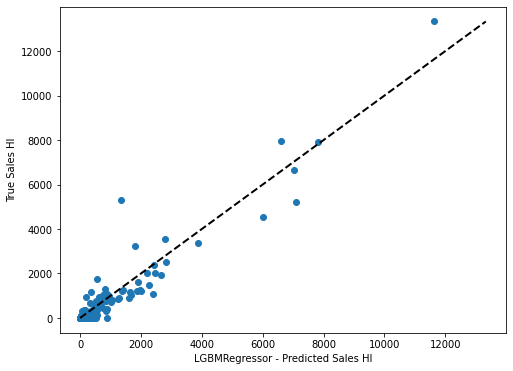

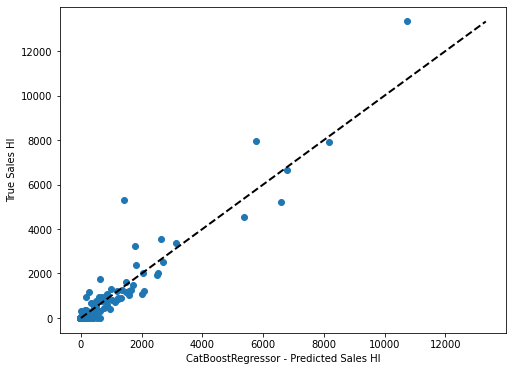

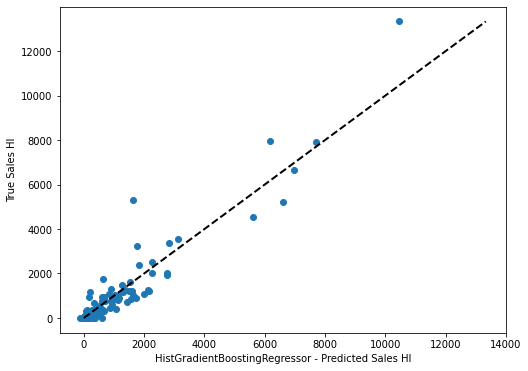

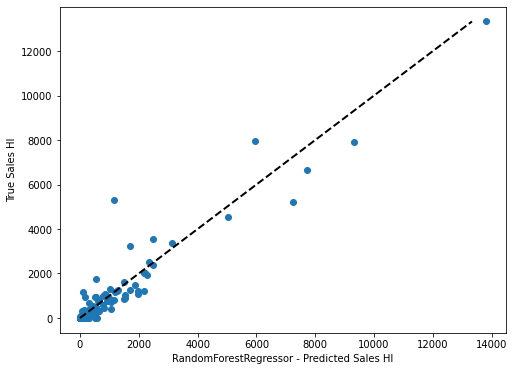

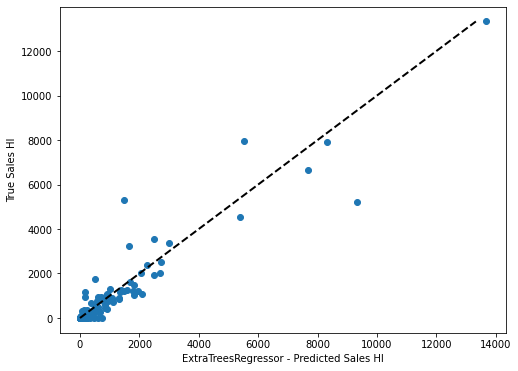

In [184]:
for key, model in estimators:
    y_pred = model.predict(X_test)
    show_pred(y_test, y_pred, f"{key} - Predicted Sales Hl", "True Sales Hl")

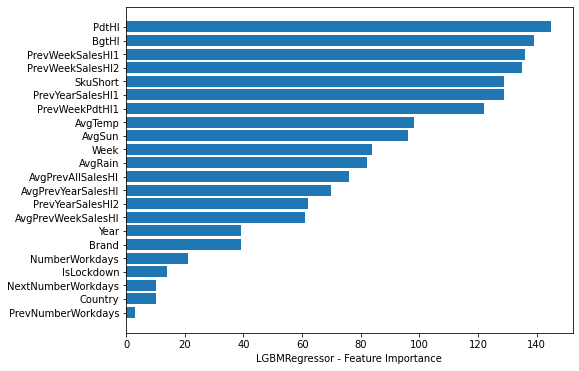

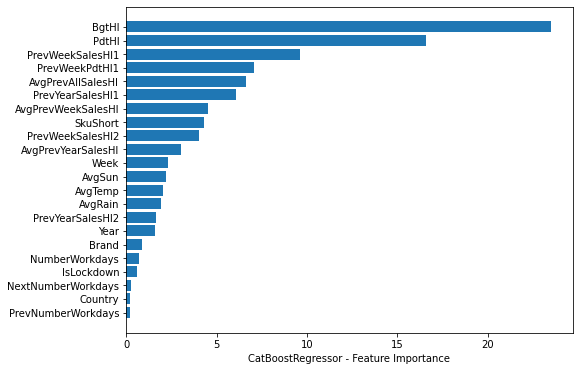

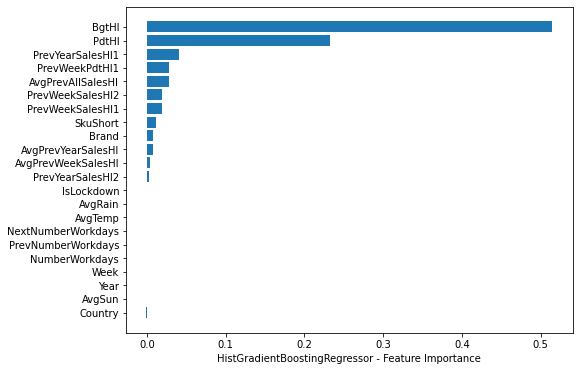

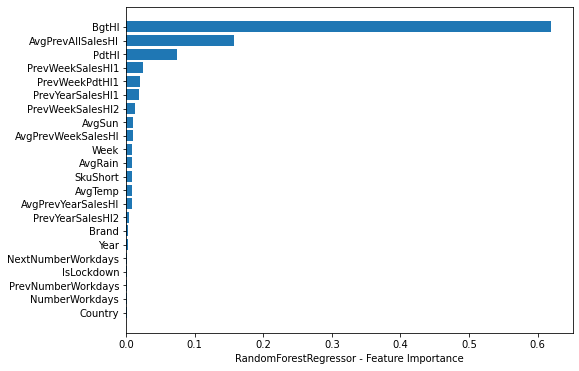

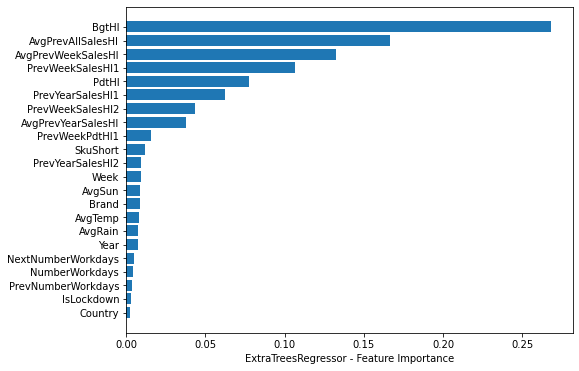

In [185]:
for key, model in estimators:
    show_feature_importances(model, X_test, y_test)

### VotingRegressor

In [186]:
%%time

model = ensemble.VotingRegressor(estimators=estimators, weights=result_models.Weights.values, n_jobs=1)

model.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = model.predict(X_test)
y_pred[y_pred < 0] = 0
y_pred = y_pred.round(0)

Wall time: 5min 5s


In [187]:
print(DATASET_NAME)
print('----------------')
print('Coefficient of determination: %.4f'% r2_score(y_test, y_pred))
print('Absolute Score: %.4f'% absolute_score(y_test, y_pred))
print('Mean absolute error regression loss.: %.4f'% mean_absolute_error(y_test, y_pred))
print('Maximum residual error: %.4f'% max_error(y_test, y_pred))
print('Mean squared error regression loss: %.4f'% mean_squared_error(y_test, y_pred))

print('----------------')

print('Classic Coefficient of determination: %.4f'% r2_score(y_test, y_test_oldPred))
print('Classic Absolute Score: %.4f'% absolute_score(y_test, y_test_oldPred))
print('Classic Mean absolute error regression loss.: %.4f'% mean_absolute_error(y_test, y_test_oldPred))
print('Classic Maximum residual error: %.4f'% max_error(y_test, y_test_oldPred))
print('Classic Mean squared error regression loss: %.4f'% mean_squared_error(y_test, y_test_oldPred))


off-trade_all
----------------
Coefficient of determination: 0.9132
Absolute Score: 0.6729
Mean absolute error regression loss.: 181.9286
Maximum residual error: 3925.0000
Mean squared error regression loss: 190017.1489
----------------
Classic Coefficient of determination: 0.9651
Classic Absolute Score: 0.8329
Classic Mean absolute error regression loss.: 92.9209
Classic Maximum residual error: 2617.1000
Classic Mean squared error regression loss: 76376.2249


In [188]:
# on-trade
# ----------------
# Coefficient of determination: 0.9582
# Absolute Score: 0.8139
# Mean absolute error regression loss.: 95.9693
# Maximum residual error: 2890.5000
# Mean squared error regression loss: 67592.0822


# off-trade
# ----------------
# Coefficient of determination: 0.8583
# Absolute Score: 0.6249
# Mean absolute error regression loss.: 224.1787
# Maximum residual error: 6374.9000
# Mean squared error regression loss: 317901.6107


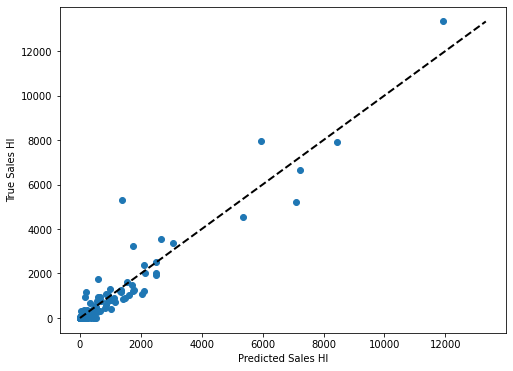

In [189]:
show_pred(y_test, y_pred, "Predicted Sales Hl", "True Sales Hl")

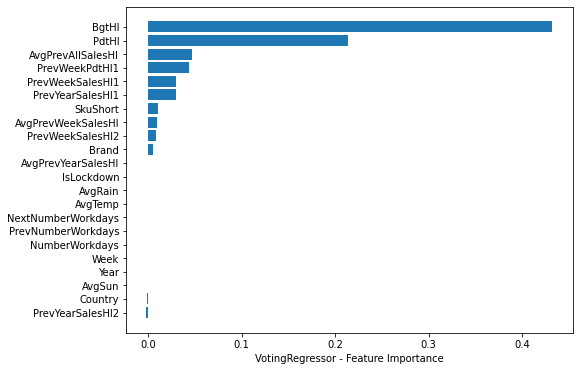

Wall time: 20.3 s


In [190]:
%%time

show_feature_importances(model, X_test, y_test)

## Save Result

In [191]:
result = X_test_raw.copy(deep=True)
result["TrueSalesHl"] = y_test
result["PredSalesHl_Classic"] = y_test_oldPred
result["PredSalesHl_ML"] = y_pred

dir_path = os.path.dirname(RESULT_CSV_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)
 
result.to_csv(RESULT_CSV_PATH, index=False)
result.to_excel(RESULT_EXCEL_PATH, index=False)

## Save model

In [192]:
dir_path = os.path.dirname(MODEL_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)

joblib.dump(model, MODEL_PATH)
joblib.dump(scaler, SCALER_PATH)
joblib.dump(imputer, IMPUTER_PATH)
joblib.dump(sku_encoder, SKU_ENCODER_PATH)
joblib.dump(brand_encoder, BRAND_ENCODER_PATH)

['./models/off-trade_all_brand_encoder.joblib']